<a href="https://colab.research.google.com/github/D0m-inic/NLP_CW/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install simpletransformers
!pip install tensorboardx
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 641.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 788.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.0 MB/s eta 0:00:00
  

In [1]:
# from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
import torch
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from ast import literal_eval

# Helper Functions + Setup

In [2]:
# Prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Check GPU
!nvidia-smi

cuda_available = torch.cuda.is_available()

print('Cuda available?', cuda_available)

Wed Feb 26 19:26:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
if cuda_available:
  import tensorflow as tf
  device = 'cuda'
  # Get the GPU device name
  device_name = tf.test.gpu_device_name()

  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')
else:
   device = 'cpu'

Found GPU at: /device:GPU:0


In [4]:
# Save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')


# Fetch Official Datasets + Splits

In [ ]:
import os

# MARK: Clone updated dataset
if not os.path.exists('augmented_dataset.csv'):
  !wget -O augmented_dataset.csv "https://raw.githubusercontent.com/D0m-inic/NLP_CW/refs/heads/main/positive_augmented_2x.csv"

# Clone Task 1 dataset
if not os.path.exists('dontpatronizeme_pcl.tsv'):
  !wget -O dontpatronizeme_pcl.tsv "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

# Clone Task 2 dataset
if not os.path.exists('dontpatronizeme_categories.tsv'):
  !wget -O dontpatronizeme_categories.tsv "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_categories.tsv"

# Clone Testing set with no Labels
if not os.path.exists('dontpatronizeme_test.tsv'):
  !wget -O dontpatronizeme_test.tsv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/TEST/task4_test.tsv"

# Clone dev set labels: `dev_semeval_parids-labels.csv`
if not os.path.exists('dev_semeval_parids-labels.csv'):
  !wget -O dev_semeval_parids-labels.csv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"

# Clone train set labels: `train_semeval_parids-labels.csv`
if not os.path.exists('train_semeval_parids-labels.csv'):
  !wget -O train_semeval_parids-labels.csv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"

# Fetch the data loader from original author
if not os.path.exists('dont_patronize_me.py'):
  !wget -O dont_patronize_me.py "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"

In [6]:
from dont_patronize_me import DontPatronizeMe

In [7]:
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load Official Splits

In [11]:
# Load practice splits for official train and dev sets
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [12]:
# Load official splits into memory
train_df = dpm.train_task1_df[dpm.train_task1_df['par_id'].isin(trids.par_id)] # Official Train
official_dev_df = dpm.train_task1_df[dpm.train_task1_df['par_id'].isin(teids.par_id)] # Official Validation

print("Official Training Set size:", train_df.shape)
print("Official Dev Set size:", official_dev_df.shape)

Official Training Set size: (8375, 7)
Official Dev Set size: (2094, 7)


## Training / Validation Splits

In [13]:
# Split the official training set into internal training and internal validation
from sklearn.model_selection import train_test_split

validation_ratio = 0.2
internal_train_df, internal_val_df = train_test_split(train_df, test_size=validation_ratio, random_state=42, stratify=train_df['label'])

print("Internal Training Set size:", internal_train_df.shape)
print("Internal Validation Set size:", internal_val_df.shape)

Internal Training Set size: (6700, 7)
Internal Validation Set size: (1675, 7)




# Rebuild DataFrames with Standardised Columns

In [14]:
def standardise_columns(df, include_label=True):
  """
  Select the desired columns and rename 'keyword' to 'community'
  include_label is False => 'label' column is omitted
  """
  if include_label:
      new_df = df[['par_id', 'keyword', 'text', 'label']].copy()
      new_df = new_df.rename(columns={'keyword': 'community'})
  else:
      # For cases where no label is available (e.g. test set)
      new_df = df[['par_id', 'keyword', 'text']].copy()
      new_df = new_df.rename(columns={'keyword': 'community'})
  return new_df

In [15]:
# Standardise the internal training and validation sets.
internal_train_df = standardise_columns(internal_train_df, include_label=True)
internal_val_df   = standardise_columns(internal_val_df, include_label=True)
internal_test_df = standardise_columns(official_dev_df, include_label=True)

#### Load Augmented Dataset

In [16]:
augmented_train_set = pd.read_csv('augmented_dataset.csv')
augmented_train_set
print(f"Class distribution: {augmented_train_set['label'].value_counts()}")

Class distribution: label
0    6065
1    1905
Name: count, dtype: int64


## Build Evaluation Test DataFrame

In [17]:
test_rows = []
with open('dontpatronizeme_test.tsv', encoding='utf-8') as f:
    # Skip the header lines (assumes the first 4 lines are headers)
    lines = f.readlines()[4:]
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) < 5:
            print("Warning: unexpected line format:", line)
            continue
        par_id, art_id, keyword, country, text = parts[:5]
        test_rows.append({
            'par_id': par_id,
            'art_id': art_id,
            'community': keyword,
            'country': country,
            'text': text
        })

test_df = pd.DataFrame(test_rows)

## TextDataset (add 10/02)

In [17]:
from torch.utils.data import Dataset

# Custom class for handling input data - prepares text and labels to be fed into model

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, label_column='label'):
        self.text = df['text'].tolist()
        self.labels = df[label_column].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.text[index],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
        )

        item = {k: torch.tensor(v) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[index], dtype=torch.long)

        return item


# Data Analysis


## Frequency Analysis

In [ ]:
data = pd.concat([official_dev_df, train_df])
print(data.keys())

Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')


Label counts (0 = negative, 1 = positive):
label
0    7581
1     794
Name: count, dtype: int64


<ipython-input-17-012c1c2822eb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


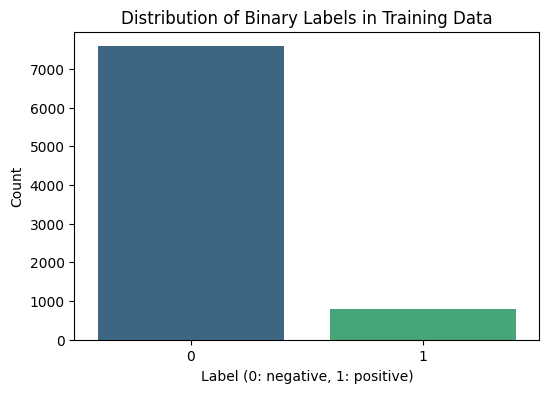

In [ ]:
label_counts = train_df['label'].value_counts().sort_index()

print("Label counts (0 = negative, 1 = positive):")
print(label_counts)

# Visualisation
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Label (0: negative, 1: positive)")
plt.ylabel("Count")
plt.title("Distribution of Binary Labels in Training Data")
plt.show()

## Input Length Analysis

<ipython-input-18-c9b499b2e5f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
<ipython-input-18-c9b499b2e5f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  official_dev_df['text_length'] = official_dev_df['text'].apply(lambda x: len(x.split()))


Text Legnth Statistics by Label:
        count       mean        std  min   25%   50%   75%    max
label                                                            
0      7581.0  48.167656  29.183814  1.0  30.0  42.0  59.0  909.0
1       794.0  53.521411  33.673945  6.0  33.0  47.0  66.0  512.0


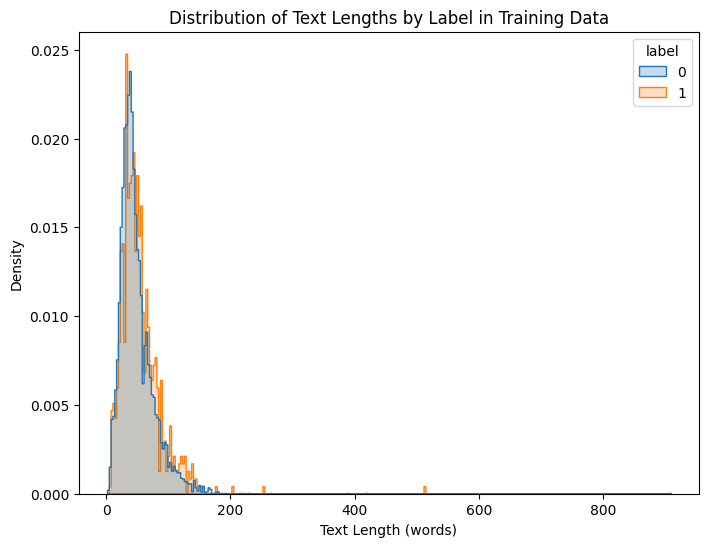

In [ ]:
# Add new column for length of each text entry. Split on whitespace (assumption - should tokenize)
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
official_dev_df['text_length'] = official_dev_df['text'].apply(lambda x: len(x.split()))

length_stats = train_df.groupby('label')['text_length'].describe()
print("Text Legnth Statistics by Label:")
print(length_stats)

# Visualisation
plt.figure(figsize=(8,6))
sns.histplot(data=train_df, x="text_length", hue="label", element="step", stat="density", common_norm=False)
plt.xlabel("Text Length (words)")
plt.title("Distribution of Text Lengths by Label in Training Data")
plt.show()

In [ ]:
# Display breakdown of P/N per community
community_label_counts = (
    data.groupby(['keyword', 'label'])
        .size()
        # .reset_index(name='count')
)

# label_mapping = {0: 'Negative (0)', 1: 'Positive (1)'}
# community_label_counts['Label'] = community_label_counts['label'].map(label_mapping)



# plt.figure(figsize=(12, 6))
# ax = sns.barplot(
#     x='keyword',
#     y='count',
#     hue='Label',
#     data=community_label_counts,
#     palette='viridis'
# )

# # Customize the plot
# ax.set_title("Positive vs Negative Counts per Community")
# ax.set_xlabel("Community")
# ax.set_ylabel("Count")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Group by community (keyword) and label to get the counts
community_label_counts = data.groupby(['keyword', 'label']).size()

# Convert the Series to a DataFrame for easier manipulation
community_label_counts_df = community_label_counts.reset_index(name='count')

# Pivot the DataFrame so that each community is a row and label counts are in columns.
# Fill missing values with 0 (in case a community doesn't have any examples of a given label)
pivot_df = community_label_counts_df.pivot(index='keyword', columns='label', values='count').fillna(0)

# For clarity, rename the columns if desired:
pivot_df = pivot_df.rename(columns={0: 'Negative', 1: 'Positive'})

# Calculate the total number of examples per community
pivot_df['Total'] = pivot_df.sum(axis=1)

# Calculate the ratios (i.e., the fraction of examples that are negative or positive)
pivot_df['Ratio_Negative'] = pivot_df['Negative'] / pivot_df['Total']
pivot_df['Ratio_Positive'] = pivot_df['Positive'] / pivot_df['Total']

# Print out the ratios per community
print(pivot_df[['Ratio_Negative', 'Ratio_Positive']])


label          Ratio_Negative  Ratio_Positive
keyword                                      
disabled             0.921206        0.078794
homeless             0.834726        0.165274
hopeless             0.876617        0.123383
immigrant            0.971725        0.028275
in-need              0.837338        0.162662
migrant              0.966942        0.033058
poor-families        0.834983        0.165017
refugee              0.919476        0.080524
vulnerable           0.925926        0.074074
women                0.951402        0.048598


In [ ]:
task2_df = dpm.train_task2_df

print("Task 2 DataFrame shape:", task2_df.shape)

Task 2 DataFrame shape: (993, 6)


## Frequency of each category

Frequency of each Task 2 category:
Unbalanced_power_relations    716
Compassion                    469
Authority_voice               230
Presupposition                224
Metaphors                     197
Shallow_solution              196
The_poorer_the_merrier         40
dtype: int64


<ipython-input-21-9e429448f0a2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="magma")


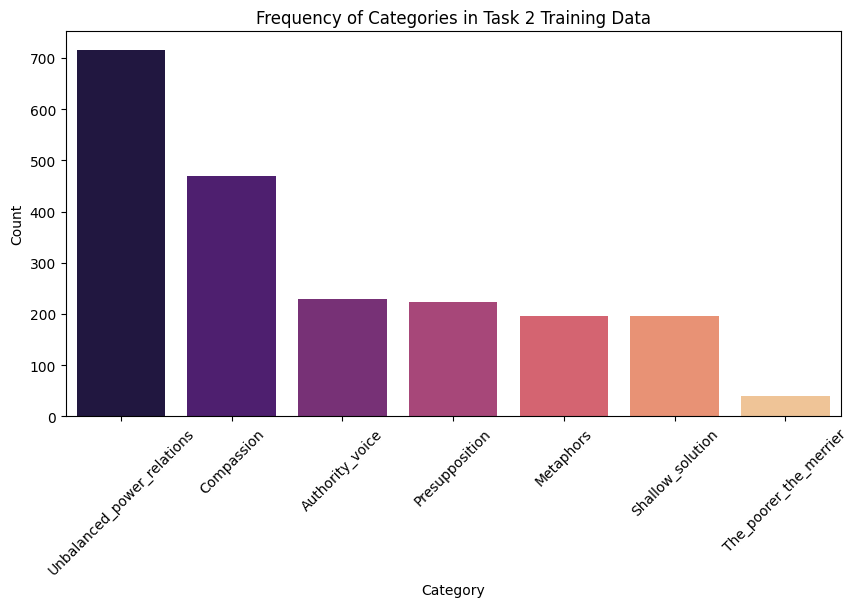

In [ ]:
categories = ['Unbalanced_power_relations', 'Shallow_solution', 'Presupposition',
              'Authority_voice', 'Metaphors', 'Compassion', 'The_poorer_the_merrier']

labels_array = np.array(task2_df['label'].tolist())
labels_df = pd.DataFrame(labels_array, columns=categories)

category_counts = labels_df.sum().sort_values(ascending=False)
print("Frequency of each Task 2 category:")
print(category_counts)

# Plot category frequencies
plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="magma")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Frequency of Categories in Task 2 Training Data")
plt.xticks(rotation=45)
plt.show()

## Categories per example

Summary statistics for the number of categories per example:
count    993.000000
mean       2.086606
std        0.940011
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: num_categories, dtype: float64


<ipython-input-22-64099f0642fa>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=task2_df['num_categories'], palette="coolwarm")


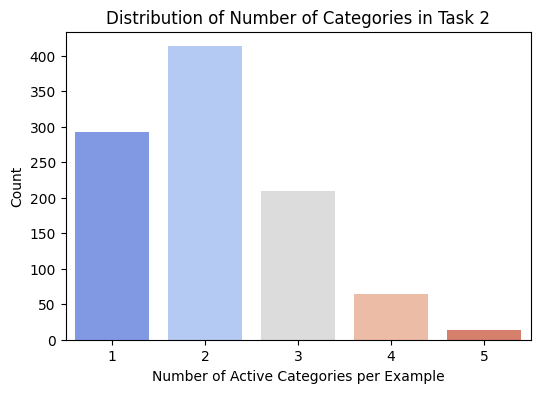

In [ ]:
#

task2_df['num_categories'] = labels_df.sum(axis=1)
print("Summary statistics for the number of categories per example:")
print(task2_df['num_categories'].describe())

plt.figure(figsize=(6,4))
sns.countplot(x=task2_df['num_categories'], palette="coolwarm")
plt.xlabel("Number of Active Categories per Example")
plt.ylabel("Count")
plt.title("Distribution of Number of Categories in Task 2")
plt.show()

# Modifications

## 1 - Data Augmentation

Minority class (PCL Langugage) is augmented twice, and the additional augmentations are added to the dataset. After augmentation, the ration of positive to negative examples is now 3:10

Majority class (Non PCL Language) is not augmented

In [ ]:
# import nlpaug.augmenter.word as naw

# positive_examples = internal_train_df[internal_train_df['label'] == 1]
# print(f"Examples: {len(positive_examples)}")

# aug = naw.ContextualWordEmbsAug(model_path='distilroberta-base', action="substitute")
# examples_augmented = 0

# augmented_positive_examples = []
# for index, row in positive_examples.iterrows():
#   augmented_texts = aug.augment(row['text'], n=2)
#   augmented_positive_examples.extend([(row['par_id'], row['community'], text, 1) for text in augmented_texts])

#   examples_augmented += 1
#   if examples_augmented % 100 == 0:
#     print(f"{examples_augmented} examples augmented")

# augmented_positive_df = pd.DataFrame(augmented_positive_examples, columns=['par_id', 'community', 'text', 'label'])
# augmented_positive_df = augmented_positive_df.sample(frac=1, random_state=42).reset_index(drop=True)

# internal_train_df = pd.concat([internal_train_df, augmented_positive_df], ignore_index=True)
# internal_train_df.to_csv("positive_augmented_2x.csv")





## 2 - Combine Augmentation with LLRD

Grouped Layer-Wise Learning Rate Decay (LLRD) optimises the learning rate in different layers to capture more diverse and fine-trained linguistic features that contribute to the meaning (PCL) with the different types of information that different layers store

In [ ]:
# Don't need to run on COLAB
# !pip install transformers

In [ ]:
# # MARK: Imports for different models

# # from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, AdamW
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, AdamW

# # Load Pretrained DistilBERT model
# model_name = "distilbert-base-uncased"
# num_labels = 2  # binary classification

# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

SyntaxError: invalid syntax (<ipython-input-26-6bab435be491>, line 1)

In [18]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer, RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, AdamW

num_labels = 2  # binary classification

# Load Pretrained DeBERTa model
deberta_model_name = "microsoft/deberta-base"
deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_model_name)
deberta_model = DebertaForSequenceClassification.from_pretrained(deberta_model_name, num_labels=num_labels)

# Load Pretrained DeBERTa model
roberta_model_name = "roberta-base" # or "roberta-large"
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def get_optimizer_grouped_parameters(model, weight_decay, base_lr, layer_decay):
    no_decay = ["bias", "LayerNorm.weight"] # Ignore these

    if hasattr(model, "roberta"):
        # ========== RoBERTa ==========
        backbone = model.roberta
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    elif hasattr(model, "distilbert"):
        # ========== DistilBERT ==========
        backbone = model.distilbert
        classifier = model.classifier
        encoder_layers = backbone.transformer.layer  # DistilBERT has `transformer.layer`
    elif hasattr(model, "deberta"):
        backbone = model.deberta
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    elif hasattr(model, "electra"):
        backbone = model.electra
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    else:
        raise ValueError("Unsupported model type for LLRD. Expected RoBERTa, DeBERTa, Electra, or DistilBERT.")


    num_layers = backbone.config.num_hidden_layers

    embedding_params = list(backbone.embeddings.named_parameters())

    # Group parameters in embeddings with extra decay
    optimizer_grouped_parameters = []
    optimizer_grouped_parameters.append({
        "params": [p for n, p in embedding_params if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": base_lr * (layer_decay ** (num_layers + 1))
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in embedding_params if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": base_lr * (layer_decay ** (num_layers + 1))
    })

    # Group parameters in each encoder layer
    for i in range(num_layers):
        layer = encoder_layers[i]
        lr_scale = base_lr * (layer_decay ** (num_layers - i))

        layer_params = list(layer.named_parameters())
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer_params if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
            "lr": lr_scale
        })
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer_params if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": lr_scale
        })

    # Group parameters in the classifer head with base_lr
    classifer_params = list(model.classifier.named_parameters())
    optimizer_grouped_parameters.append({
        "params": [p for n, p in classifer_params if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": base_lr
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in classifer_params if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": base_lr
    })

    return optimizer_grouped_parameters

In [20]:
# MARK: Hyperparameters
base_lr = 5e-5
weight_decay = 0.01
layer_decay = 0.8
max_length = 512

deberta_optimizer_grouped_params = get_optimizer_grouped_parameters(deberta_model, weight_decay, base_lr, layer_decay)
roberta_model_grouped_params = get_optimizer_grouped_parameters(roberta_model, weight_decay, base_lr, layer_decay)
# print(optimzer_grouped_params)
deberta_optimizer = AdamW(deberta_optimizer_grouped_params, lr=base_lr)
roberta_optimizer = AdamW(roberta_model_grouped_params, lr=base_lr)
# optimizer = AdamW(deberta_optimizer_grouped_params + roberta_model_grouped_params, lr=base_lr)

# Load val set
# roberta_val_dataset = TextDataset(internal_val_df, roberta_tokenizer, max_length=max_length, label_column='label')
# deberta_val_dataset = TextDataset(internal_val_df, deberta_tokenizer, max_length=max_length, label_column='label')

# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=1,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     evaluation_strategy="epoch",
#     logging_dir='/logs',
#     learning_rate=base_lr,
#     weight_decay=weight_decay,
#     report_to="none"
# )

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 3 - Ensemble Models

In [ ]:
!pip install evaluate

In [ ]:
pip install datasets


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import evaluate

class RobertaDebertaEnsemble(nn.Module):
    def __init__(self, roberta_model, deberta_model):
        """
        Ensemble model that averages logits from RoBERTa and DeBERTa.

        Args:
            roberta_model (str): Hugging Face model name for RoBERTa.
            deberta_model (str): Hugging Face model name for DeBERTa.
            num_labels (int): Number of output classes.
        """
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Load models
        self.roberta = roberta_model.to(self.device)
        self.deberta = deberta_model.to(self.device)

    def forward(self, roberta_inputs, deberta_inputs):
        """
        Forward pass for both models.

        Args:
            roberta_inputs (dict): Tokenized input for RoBERTa.
            deberta_inputs (dict): Tokenized input for DeBERTa.

        Returns:
            torch.Tensor: Averaged logits from both models.
        """
        roberta_logits = self.roberta(**roberta_inputs).logits
        deberta_logits = self.deberta(**deberta_inputs).logits

        # Average logits
        ensemble_logits = (roberta_logits + deberta_logits) / 2
        return ensemble_logits

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer_roberta, tokenizer_deberta, max_length=512, label_column='label'):
        # self.texts = df['text'].tolist()
        # self.labels = df[label_column].tolist()
        # self.tokenizer_roberta = tokenizer_roberta
        # self.tokenizer_deberta = tokenizer_deberta
        # self.max_length = max_length

        self.tokenized_roberta = tokenizer_roberta(
            df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt'
        )
        self.tokenized_deberta = tokenizer_deberta(
            df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt'
        )
        self.labels = torch.tensor(df[label_column].tolist(), dtype=torch.long)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            {k: v[idx] for k, v in self.tokenized_roberta.items()},
            {k: v[idx] for k, v in self.tokenized_deberta.items()},
            self.labels[idx]
        )

    # def __getitem__(self, idx):
    #     roberta_encoding = self.tokenizer_roberta(
    #         self.texts[idx],
    #         truncation=True,
    #         padding='max_length',
    #         max_length=self.max_length,
    #         return_tensors='pt'
    #     )
    #     deberta_encoding = self.tokenizer_deberta(
    #         self.texts[idx],
    #         truncation=True,
    #         padding='max_length',
    #         max_length=self.max_length,
    #         return_tensors='pt'
    #     )

    #     roberta_item = {k: v.squeeze(0) for k, v in roberta_encoding.items()}
    #     deberta_item = {k: v.squeeze(0) for k, v in deberta_encoding.items()}

    #     label = torch.tensor(self.labels[idx], dtype=torch.long)

    #     return roberta_item, deberta_item, label



# Training Function
def train_ensemble(model, train_loader, val_loader, optimizer_roberta, optimizer_deberta, criterion, num_epochs=10):

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        preds = []

        print(f"Epoch {epoch+1}/{num_epochs}")
        print("---------------------------------")

        model.train()
        for roberta_inputs, deberta_inputs, labels in train_loader:
            # Move to device
            roberta_inputs = {key: val.to(model.device) for key, val in roberta_inputs.items()}
            deberta_inputs = {key: val.to(model.device) for key, val in deberta_inputs.items()}
            labels = labels.to(model.device)

            # Zero gradients for both optimizers
            optimizer_roberta.zero_grad()
            optimizer_deberta.zero_grad()

            logits = model(roberta_inputs, deberta_inputs) # Forward pass

            loss = criterion(logits, labels) # Compute loss


            loss.backward() # Backward pass

            # Step optimizers separately
            optimizer_roberta.step()
            optimizer_deberta.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

        model.eval()
        with torch.no_grad():
            for roberta_inputs, deberta_inputs, labels in val_loader:
                # Move to device
                roberta_inputs = {key: val.to(model.device) for key, val in roberta_inputs.items()}
                deberta_inputs = {key: val.to(model.device) for key, val in deberta_inputs.items()}

                labels = labels.to(model.device)

                logits = model(roberta_inputs, deberta_inputs)

                pred = torch.argmax(logits, dim=-1)

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                preds.extend(pred.cpu().tolist())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        metric = evaluate.load("f1")
        print(f"F1 Score: {metric.compute(predictions=preds, references=internal_val_df.label.tolist())}")


In [23]:
print("Using device", device)

positive_examples = augmented_train_set[augmented_train_set.label == 1]
negative_examples = augmented_train_set[augmented_train_set.label == 0]

current_training_set = pd.concat([positive_examples,
                                    negative_examples.sample(n=len(positive_examples) * 2, random_state=1)])
current_training_set = current_training_set.sample(frac=1, random_state=1).reset_index(drop=True)

# Create dataset and dataloader
trainset = CustomDataset(current_training_set, roberta_tokenizer, deberta_tokenizer)
valset = CustomDataset(internal_val_df, roberta_tokenizer, deberta_tokenizer)

train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

# Initialize model and optimizers
ensemble_model = RobertaDebertaEnsemble(roberta_model, deberta_model)

deberta_optimizer_grouped_params = get_optimizer_grouped_parameters(deberta_model, weight_decay, base_lr, layer_decay)
roberta_model_grouped_params = get_optimizer_grouped_parameters(roberta_model, weight_decay, base_lr, layer_decay)

deberta_optimizer = AdamW(deberta_optimizer_grouped_params, lr=base_lr)
roberta_optimizer = AdamW(roberta_model_grouped_params, lr=base_lr)

# optimizer_roberta = optim.AdamW(ensemble_model.roberta.parameters(), lr=2e-5)
# optimizer_deberta = optim.AdamW(ensemble_model.deberta.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train the model
train_ensemble(ensemble_model, train_loader, val_loader, roberta_optimizer, deberta_optimizer, criterion, num_epochs=3)

Using device cuda
Epoch 1/3
---------------------------------
Epoch [1/3], Loss: 0.3934
Validation Loss: 0.2133


F1 Score: {'f1': 0.5}
Epoch 2/3
---------------------------------
Epoch [2/3], Loss: 0.1950
Validation Loss: 0.2157
F1 Score: {'f1': 0.4676258992805755}
Epoch 3/3
---------------------------------
Epoch [3/3], Loss: 0.1019
Validation Loss: 0.3501
F1 Score: {'f1': 0.4100418410041841}


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
)

ensemble_model = EnsembleModel(deberta_model, roberta_model)
tokenized_datasets_train, tokenized_datasets_test = getEnsembleData()

trainer = Trainer(
    model=ensemble_model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    compute_metrics=compute_metrics,
    optimizers=(optimizer,None)
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/7970 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

# Simple Baseline Models

## Bag of Words with Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Perform downsampling for training dataframe as done by RoBERTa Baseline
# pcldf = trdf[trdf.label==1]
# npos = len(pcldf)

# trdf_ds = pd.concat([pcldf,trdf[trdf.label==0][:npos*2]])
positive_examples = augmented_train_set[augmented_train_set.label == 1]
negative_examples = augmented_train_set[augmented_train_set.label == 0]
trdf_ds = pd.concat([positive_examples,
                     negative_examples.sample(n=len(positive_examples) * 2, random_state=42)])
trdf_ds = trdf_ds.sample(frac=1, random_state=1).reset_index(drop=True)

# convert text from dataframe into BoW representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(trdf_ds['text'])
X_test = vectorizer.transform(internal_val_df['text'])

model = LogisticRegression(random_state=0)
model.fit(X_train, trdf_ds['label'])

y_pred = model.predict(X_test)
f1 = f1_score(internal_val_df['label'], y_pred)
print(f"F1 Score: {f1:.4f}")

## Tf-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

vectorizer_params = {
    "min_df": 0.001,
    "ngram_range": (1, 2),
    "max_features": 10000
}

vectorizer = TfidfVectorizer(**vectorizer_params)
X_train = vectorizer.fit_transform(trdf_ds['text'])
X_test = vectorizer.transform(internal_val_df['text'])

model = LogisticRegression(max_iter=10000, random_state=0)
model.fit(X_train, trdf_ds['label'])

y_pred = model.predict(X_test)
f1 = f1_score(internal_val_df['label'], y_pred)

print(f"F1 Score: {f1:.4f}")

In [ ]:
import torch.nn as nn

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

        self.c_head = nn.Sequential(
            nn.Linear(self.model1.config.hidden_size + self.model2.config.hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        model1_x = self.model1(x)
        model2_x = self.model2(x)

        return self.c_head(torch.cat([model1_x, model2_x], dim=1))

# Model Training

In [ ]:
from sklearn.metrics import f1_score
from datetime import datetime

def evaluate_f1(predictions, true_labels):
  f1 = f1_score(true_labels, predictions, pos_label=1)
  print("F1 Score (Positive Class): {:.2f}".format(f1))
  return f1

torch.cuda.empty_cache()
num_epochs = 10
positive_examples = augmented_train_set[augmented_train_set.label == 1]
negative_examples = augmented_train_set[augmented_train_set.label == 0]

current_training_set = pd.concat([positive_examples,
                                    negative_examples.sample(n=len(positive_examples) * 2, random_state=1)])
current_training_set = current_training_set.sample(frac=1, random_state=1).reset_index(drop=True)

print(f"Training set size: {len(current_training_set)}")

# deberta_train_dataset = TextDataset(current_training_set, deberta_tokenizer, max_length=max_length, label_column='label')
# roberta_train_dataset = TextDataset(current_training_set, roberta_tokenizer, max_length=max_length, label_column='label')

trainer = Trainer(
  model=deberta_model,
  args=training_args,
  train_dataset=current_training_set,
  eval_dataset=internal_val_df,
  #compute_metrics=evaluate+f1,
  optimizers=(deberta_optimizer, None)
)

deberta_model.to(device)
roberta_model.to(device)

for epoch in range(num_epochs):
  print(f"\nEpoch {epoch+1}/{num_epochs}")
  print("---------------------------------")


  deberta_trainer.train()
  roberta_trainer.train()
  del roberta_train_dataset

  deberta_model.eval()
  roberta_model.eval()
  deberta_predictions = []
  roberta_predictions = []
  ensemble_predictions = []
  print("Evaluating:")
  with torch.no_grad():
      for text in internal_val_df.text.tolist():
          deberta_inputs = deberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
          roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

          deberta_outputs = deberta_model(**deberta_inputs)
          roberta_outputs = roberta_model(**roberta_inputs)
          ensemble_outputs = (deberta_outputs.logits + roberta_outputs.logits) / 2

          deberta_pred = torch.argmax(deberta_outputs.logits, dim=-1).item() # binary classification
          roberta_pred = torch.argmax(roberta_outputs.logits, dim=-1).item() # binary classification
          ensemble_pred = torch.argmax(ensemble_outputs, dim=-1).item() # binary classification

          deberta_predictions.append(deberta_pred)
          roberta_predictions.append(roberta_pred)
          ensemble_predictions.append(ensemble_pred)

  deberta_f1 = evaluate_f1(deberta_predictions, internal_val_df['label'].tolist())
  roberta_f1 = evaluate_f1(roberta_predictions, internal_val_df['label'].tolist())
  ensemble_f1 = evaluate_f1(ensemble_predictions, internal_val_df['label'].tolist())
  print(f"Deberta f1: {deberta_f1}")
  print(f"Roberta f1: {roberta_f1}")
  print(f"Ensemble f1: {ensemble_f1}")

  torch.cuda.empty_cache()

# trainer.train()
# eval_results = trainer.evaluate()
# print("LLRD with ELECTRA evaluation results:", eval_results)

In [ ]:
from sklearn.metrics import f1_score
from datetime import datetime

def evaluate_f1(predictions, true_labels):
  f1 = f1_score(true_labels, predictions, pos_label=1)
  print("F1 Score (Positive Class): {:.2f}".format(f1))
  return f1

torch.cuda.empty_cache()
num_epochs = 10
positive_examples = augmented_train_set[augmented_train_set.label == 1]
negative_examples = augmented_train_set[augmented_train_set.label == 0]

current_training_set = pd.concat([positive_examples,
                                    negative_examples.sample(n=len(positive_examples) * 2, random_state=1)])
current_training_set = current_training_set.sample(frac=1, random_state=1).reset_index(drop=True)

print(f"Training set size: {len(current_training_set)}")

deberta_train_dataset = TextDataset(current_training_set, deberta_tokenizer, max_length=max_length, label_column='label')
roberta_train_dataset = TextDataset(current_training_set, roberta_tokenizer, max_length=max_length, label_column='label')

deberta_trainer = Trainer(
  model=deberta_model,
  args=training_args,
  train_dataset=deberta_train_dataset,
  eval_dataset=deberta_val_dataset,
  #compute_metrics=evaluate+f1,
  optimizers=(deberta_optimizer, None)
)

roberta_trainer = Trainer(
  model=roberta_model,
  args=training_args,
  train_dataset=roberta_train_dataset,
  eval_dataset=roberta_val_dataset,
  #compute_metrics=evaluate+f1,
  optimizers=(roberta_optimizer, None)
)

deberta_model.to(device)
roberta_model.to(device)

for epoch in range(num_epochs):
  print(f"\nEpoch {epoch+1}/{num_epochs}")
  print("---------------------------------")


  deberta_trainer.train()
  roberta_trainer.train()
  del roberta_train_dataset

  deberta_model.eval()
  roberta_model.eval()
  deberta_predictions = []
  roberta_predictions = []
  ensemble_predictions = []
  print("Evaluating:")
  with torch.no_grad():
      for text in internal_val_df.text.tolist():
          deberta_inputs = deberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
          roberta_inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

          deberta_outputs = deberta_model(**deberta_inputs)
          roberta_outputs = roberta_model(**roberta_inputs)
          ensemble_outputs = (deberta_outputs.logits + roberta_outputs.logits) / 2

          deberta_pred = torch.argmax(deberta_outputs.logits, dim=-1).item() # binary classification
          roberta_pred = torch.argmax(roberta_outputs.logits, dim=-1).item() # binary classification
          ensemble_pred = torch.argmax(ensemble_outputs, dim=-1).item() # binary classification

          deberta_predictions.append(deberta_pred)
          roberta_predictions.append(roberta_pred)
          ensemble_predictions.append(ensemble_pred)

  deberta_f1 = evaluate_f1(deberta_predictions, internal_val_df['label'].tolist())
  roberta_f1 = evaluate_f1(roberta_predictions, internal_val_df['label'].tolist())
  ensemble_f1 = evaluate_f1(ensemble_predictions, internal_val_df['label'].tolist())
  print(f"Deberta f1: {deberta_f1}")
  print(f"Roberta f1: {roberta_f1}")
  print(f"Ensemble f1: {ensemble_f1}")

  torch.cuda.empty_cache()

# trainer.train()
# eval_results = trainer.evaluate()
# print("LLRD with ELECTRA evaluation results:", eval_results)


Epoch 1/10
---------------------------------
Training set size: 5715


Epoch,Training Loss,Validation Loss
1,0.213900,0.447450


Epoch,Training Loss,Validation Loss
1,0.208000,0.393826


Evaluating:
F1 Score (Positive Class): 0.41
F1 Score (Positive Class): 0.50
F1 Score (Positive Class): 0.45
Deberta f1: 0.4063745019920319
Roberta f1: 0.49645390070921985
Ensemble f1: 0.44621513944223107

Epoch 2/10
---------------------------------
Training set size: 5715


Epoch,Training Loss,Validation Loss
1,0.282800,0.375712


Epoch,Training Loss,Validation Loss
1,0.296000,0.431839


Evaluating:
F1 Score (Positive Class): 0.46
F1 Score (Positive Class): 0.43
F1 Score (Positive Class): 0.46
Deberta f1: 0.46387832699619774
Roberta f1: 0.43410852713178294
Ensemble f1: 0.46215139442231074

Epoch 3/10
---------------------------------
Training set size: 5715


Epoch,Training Loss,Validation Loss
1,0.177200,0.465932


Epoch,Training Loss,Validation Loss
1,0.206400,0.572499


Evaluating:
F1 Score (Positive Class): 0.46
F1 Score (Positive Class): 0.42
F1 Score (Positive Class): 0.44
Deberta f1: 0.456
Roberta f1: 0.4180327868852459
Ensemble f1: 0.44166666666666665

Epoch 4/10
---------------------------------
Training set size: 5715


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
## MARK: Simple Transformers roberta

# task1_model_args = ClassificationArgs(num_train_epochs=1,
#                                       no_save=True,
#                                       no_cache=True,
#                                       overwrite_output_dir=True)
# task1_model = ClassificationModel("roberta",
#                                   'roberta-base',
#                                   args = task1_model_args,
#                                   num_labels=2,
#                                   use_cuda=cuda_available)
# # Train model
# task1_model.train_model(training_set1[['text', 'label']])

# # Run predictions
# preds_task1, _ = task1_model.predict(internal_val_df.text.tolist())

# Model Evaluation

In [ ]:
from sklearn.metrics import f1_score
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-23): 24 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (L

In [ ]:
def predict_texts(model, texts, tokenizer, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs = model(**inputs)

            pred = torch.argmax(outputs.logits, dim=-1).item() # binary classification
            predictions.append(pred)
    return predictions

def evaluate_f1(predictions, true_labels):
  f1 = f1_score(true_labels, predictions, pos_label=1)
  print("F1 Score (Positive Class): {:.2f}".format(f1))
  return f1

# Validation Set
# val_preds_task1, _ = model.predict(internal_val_df.text.tolist()) # Simple Transformers forward function
val_preds_task1 = predict_texts(model, internal_val_df.text.tolist(), tokenizer, device) # Hugging Face forward function
val_f1 = evaluate_f1(val_preds_task1, internal_val_df['label'].tolist())

# Test Set
# test_preds_task1, _ = model.predict(internal_test_df.text.tolist())
test_preds_task1 = predict_texts(model, internal_test_df.text.tolist(), tokenizer, device)
test_f1 = evaluate_f1(test_preds_task1, internal_test_df['label'].tolist())


model_name = "4 - Electra with LLRD"
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
results_text = (
    f"Results for {model_name}\n"
    f"Date: {current_time}\n"
    f"Validation F1 Score: {val_f1:.2f}\n"
    f"Test F1 Score: {test_f1:.2f}\n"
    "---------------------------------\n"
)

results_filename = "results.txt"
with open(results_filename, "a", encoding="utf-8") as f:
  f.write(results_text)

print(f"Results saved to {results_filename}")


F1 Score (Positive Class): 0.36
F1 Score (Positive Class): 0.38
Results saved to results.txt
